In [1]:
from commons import input_iterator
import pandas as pd
import os
import datetime
import gzip
import glob
import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
import shutil
import multiprocessing
from sklearn.metrics import accuracy_score

2022-09-04 02:30:43.793681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# df_split = pd.read_csv("/mnt/nfs/niddk/ACT_final_randomization_5-13-2019.csv")

# test_ids = df_split[df_split['Randomization'] == 'test']['ID']

# all_data = glob.glob("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed/*/*")

# test_files = sorted([x for x in all_data if int(os.path.basename(x)) in set(test_ids)])

# out_root = "/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed_sampled"
# shutil.rmtree(out_root, ignore_errors=True)
# os.makedirs(out_root)
# partition = 8
# def apply_fn(x):
#     i = x[0]
#     test_dir = x[1]
#     out_dir = os.path.join(out_root, str(i % partition))
#     oid = os.path.basename(test_dir)
#     dirname = os.path.dirname(test_dir)
#     fnames = [name.split('.')[0] for name in os.listdir(test_dir) if not name.startswith('.')]
#     fnames.sort()
#     for i in range(len(fnames) - 1):
#         assert datetime.datetime.strptime(fnames[i+1], "%Y-%m-%d").date() - datetime.datetime.strptime(fnames[i], "%Y-%m-%d").date() == datetime.timedelta(days=1)
    
#     for i, fname in enumerate(fnames):
#         h5f = h5py.File(os.path.join(test_dir, '{}.h5'.format(fname)), 'r')
#         if i == 0:
#             timestamps = h5f.get('time')[:]
#             data = h5f.get('data')[:]
#             sleeping = h5f.get('sleeping')[:]
#             non_wear = h5f.get('non_wear')[:]
#             label = h5f.get('label')[:]
#         else:
#             timestamps = np.concatenate((timestamps, h5f.get('time')[:]))
#             data = np.concatenate((data, h5f.get('data')[:]))
#             sleeping = np.concatenate((sleeping, h5f.get('sleeping')[:]))
#             non_wear = np.concatenate((non_wear, h5f.get('non_wear')[:]))
#             label = np.concatenate((label, h5f.get('label')[:]))
#     labeld_indices = np.where(label != -1)[0]
#     sampled_indices = np.random.choice(labeld_indices, 100, replace=False) 
#     interval = 10
#     desired = 14 * 60
#     first_half = 7 * 60
#     need = desired // interval
#     for idx in sampled_indices:
#         sublabel = label[idx:idx + need]
#     #     all labeld and enough
#         if sublabel.shape[0] == need and np.where(sublabel == -1)[0].shape[0] == 0:
#             for offset in np.array([x for x in range(1, 8)]) * 6 + first_half // interval:
#     #             print(offset)
#                 sub_timestamps = timestamps[idx:idx + offset]
#                 sub_data = data[idx:idx + offset]
#                 sub_sleeping = sleeping[idx:idx + offset]
#                 sub_non_wear = non_wear[idx:idx + offset]
#                 sub_label = label[idx:idx + offset]
                
#                 name = "{}_{}_{}".format(oid, idx, offset)
#                 dummy_name = fnames[0] + '.h5'
#                 sample_out_dir = os.path.join(out_dir, name)
#                 Path(sample_out_dir).mkdir(parents=True, exist_ok=True)
#                 out_filename = os.path.join(sample_out_dir, dummy_name)
#                 h5f_out = h5py.File(out_filename, "w")
#                 h5f_out.create_dataset('time', data=sub_timestamps, chunks=True, maxshape=(None,))
#                 h5f_out.create_dataset('data', data=sub_data, chunks=True, maxshape=(None, 100, 3))
#                 h5f_out.create_dataset('non_wear', data=sub_non_wear, chunks=True, maxshape=(None,))
#                 h5f_out.create_dataset('sleeping', data=sub_sleeping, chunks=True, maxshape=(None,))
#                 h5f_out.create_dataset('label', data=sub_label, chunks=True, maxshape=(None,))
#                 h5f_out.close()

# pool = multiprocessing.Pool(processes=40)
# mapped_values = list(tqdm(
#     pool.imap_unordered(apply_fn, list(enumerate(test_files))), total=len(test_files)))
# pool.close()
# pool.join()

    

100%|██████████| 213/213 [23:57<00:00,  6.75s/it]


In [68]:
h5f = h5py.File("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed_sampled/7/151667_120933_48/2017-10-23.h5", 'r')

In [71]:
len(h5f.get('label')[:])

27

In [84]:
def read_file(predfile):
    filename = os.path.basename(predfile).split('.')[0]
    oid, index, offset = filename.split("_")
    index = int(index)
    offset = int(offset)
    df = pd.read_csv(predfile)
    df['oid'] = oid
    df['index'] = index
    df['offset'] = offset
    
    df_first = df.iloc[:42]
    df_second = df.iloc[42:]
    return df_first, df_second
#     df_all_list_first.append(df.iloc[:42])
#     df_all_list_sec.append(df.iloc[42:])
    

In [162]:
def get_acc(df_all_second):
    accs = {}
    offsets = sorted(df_all_second["offset"].unique())
    for off in offsets:
        df_score = df_all_second[df_all_second['offset'] == off]
        minute = (off - 42) // 6
        acc = accuracy_score(df_score['label'], df_score['prediction'])
        accs[minute] = acc
    return accs

In [163]:
def read_cast(preds_root):
    

    all_preds = glob.glob(os.path.join(preds_root, "*.csv"))


    pool = multiprocessing.Pool(processes=40)
    df_list_all = list(tqdm(
        pool.imap_unordered(read_file, list(all_preds)), total=len(all_preds)))
    pool.close()
    pool.join()
    df_all_list_first = []
    df_all_list_second = []
    for df_first, df_second in df_list_all:
        df_all_list_first.append(df_first)
        df_all_list_second.append(df_second)
    df_all_first = pd.concat(df_all_list_first, ignore_index=True, sort=False)
    df_all_second = pd.concat(df_all_list_second, ignore_index=True, sort=False)
    df_all_second['correct'] = df_all_second['label'] == df_all_second['prediction']
    df_oid_groupby = df_all_second.groupby(["oid", "offset"]).agg({'correct': "sum", 'index': "count"})
    df_oid_groupby['acc'] = df_oid_groupby['correct'] / df_oid_groupby['index']
    df_7 = df_oid_groupby[df_oid_groupby.index.get_level_values(1) == 84]
    df_rel = df_oid_groupby.reset_index(level=1).merge(df_7[['acc']], on=['oid'], suffixes=('', '7'))
    df_rel['rel_acc'] = df_rel['acc'] / df_rel['acc7']
    df_rel_out = df_rel.groupby('offset').agg({'acc': "mean", 'rel_acc': "mean"})
    accs = get_acc(df_all_second)
        
    return df_all_first, df_all_second, df_rel_out, accs
    

In [ ]:
preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_WRAP/CHAP_ALL_ADULTS"
df_all_first_wrap, df_all_second_wrap, df_rel_out_wrap, accs_wrap = read_cast(preds_root)

In [107]:
preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_ZERO/CHAP_ALL_ADULTS"
df_all_first_zero, df_all_second_zero, df_rel_out_zero, accs_zero = read_cast(preds_root)

100%|██████████| 148953/148953 [01:42<00:00, 1455.16it/s]


In [110]:
print(accuracy_score(df_all_first_zero['label'], df_all_first_zero['prediction'])) 

0.8344052598246874


In [113]:
accs_zero

{1: 0.9089007942102543,
 2: 0.8804494258815421,
 3: 0.8558698978126583,
 4: 0.8410306718674123,
 5: 0.8321522001347181,
 6: 0.8301011430152837,
 7: 0.8351952181784411}

In [ ]:
df_all_second_zero

In [120]:
print(df_all_second_zero[(df_all_second_zero["oid"] == "154558") & (df_all_second_zero["index"] == 116038)].to_string())

         segment            timestamp    label prediction     oid   index  offset  correct
0              0  2017-10-02 10:26:40  sitting    sitting  154558  116038      60     True
1              0  2017-10-02 10:26:50  sitting    sitting  154558  116038      60     True
2              0  2017-10-02 10:27:00  sitting    sitting  154558  116038      60     True
3              0  2017-10-02 10:27:10  sitting    sitting  154558  116038      60     True
4              0  2017-10-02 10:27:20  sitting    sitting  154558  116038      60     True
5              0  2017-10-02 10:27:30  sitting    sitting  154558  116038      60     True
6              0  2017-10-02 10:27:40  sitting    sitting  154558  116038      60     True
7              0  2017-10-02 10:27:50  sitting    sitting  154558  116038      60     True
8              0  2017-10-02 10:28:00  sitting    sitting  154558  116038      60     True
9              0  2017-10-02 10:28:10  sitting    sitting  154558  116038      60     True

In [122]:
18 * 10 / 60

3.0

In [124]:
df_all_second_zero[df_all_second_zero['label'] == "sitting"].count() / df_all_second_zero.count()

segment       0.823398
timestamp     0.823398
label         0.823398
prediction    0.823398
oid           0.823398
index         0.823398
offset        0.823398
correct       0.823398
dtype: float64

In [111]:
print(accuracy_score(df_all_second_zero['label'], df_all_second_zero['prediction'])) 

0.842473800460548


In [87]:
# preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_WRAP/CHAP_ALL_ADULTS"

# all_preds = glob.glob(os.path.join(preds_root, "*.csv"))


# pool = multiprocessing.Pool(processes=40)
# df_list_all = list(tqdm(
#     pool.imap_unordered(read_file, list(all_preds)), total=len(all_preds)))
# pool.close()
# pool.join()


# # df_all_sec = pd.DataFrame()
# # df_all_first = pd.DataFrame()
# # df_all_list_first = []
# # df_all_list_sec = []
# # for predfile in tqdm(all_preds):
# #     filename = os.path.basename(predfile).split('.')[0]
# #     oid, index, offset = filename.split("_")
# #     index = int(index)
# #     offset = int(offset)
# #     df = pd.read_csv(predfile)
# #     df['oid'] = oid
# #     df['index'] = index
# #     df['offset'] = offset
# #     df_all_list_first.append(df.iloc[:42])
# #     df_all_list_sec.append(df.iloc[42:])
# #     df_all_first = pd.concat([df_all_first, df.iloc[:42]], ignore_index=True, sort=False)
# #     df_all_sec = pd.concat([df_all_sec, df.iloc[42:]], ignore_index=True, sort=False)

# #     df_score = df[df['label'] != "no-label"]
# #     print(accuracy_score(df_score['label'], df_score['prediction']))

100%|██████████| 148953/148953 [03:17<00:00, 753.06it/s]


In [90]:
print(accuracy_score(df_all_first['label'], df_all_first['prediction'])) 

0.8344052598246874


In [91]:
print(accuracy_score(df_all_second['label'], df_all_second['prediction'])) 

0.8339291588621914


In [96]:
# df_oid_groupby = df_oid_groupby.reset_index()
# df_7 = df_oid_groupby[df_oid_groupby.index.get_level_values(1) == 84]

In [97]:
# df_rel = df_oid_groupby.reset_index(level=1).merge(df_7[['acc']], on=['oid'], suffixes=('', '7'))

In [98]:
# df_rel['rel_acc'] = df_rel['acc'] / df_rel['acc7']

In [99]:
# df_rel.groupby('offset').agg({'acc': "mean", 'rel_acc': "mean"})

,acc,rel_acc
offset,,
48,0.843489,1.011368
54,0.836876,1.002768
60,0.832949,0.997630
66,0.831603,0.995735
72,0.831724,0.995741
78,0.833763,0.998050
84,0.835199,1.000000


In [30]:
# df_oid_groupby['rel_acc'] = df_oid_groupby['acc'] / df_7['acc']

In [100]:
df_7['acc']

oid     offset
150011  84        0.733095
150042  84        0.931429
150110  84        0.909762
150298  84        0.855000
150515  84        0.868333
                    ...   
98455   84        0.951190
99034   84        0.949524
99040   84        0.964524
99380   84        0.912381
99423   84        0.823713
Name: acc, Length: 213, dtype: float64

In [31]:
df_oid_groupby

correct  index       acc  rel_acc
oid    offset                                   
150011 66           48     48  1.000000      NaN
       72           30     60  0.500000      NaN
       78           29     36  0.805556      NaN
       84          126    126  1.000000      1.0
150042 48            6      6  1.000000      NaN
...                ...    ...       ...      ...
99423  60           18     18  1.000000      NaN
       66           24     48  0.500000      NaN
       72           30     30  1.000000      NaN
       78           36     36  1.000000      NaN
       84           83     84  0.988095      1.0

[1054 rows x 4 columns]

In [22]:
df_oid_groupby

,oid,offset,correct,index,acc
0,150011,66,48,48,1.000000
1,150011,72,30,60,0.500000
2,150011,78,29,36,0.805556
3,150011,84,126,126,1.000000
4,150042,48,6,6,1.000000
...,...,...,...,...,...
1049,99423,60,18,18,1.000000
1050,99423,66,24,48,0.500000
1051,99423,72,30,30,1.000000
1052,99423,78,36,36,1.000000


In [127]:
import matplotlib
import matplotlib.font_manager
from matplotlib import pyplot as plt
import seaborn as sns
class PlotterBase(object):
    def __init__(
            self,
            xlabel=None,
            ylabel=None,
            title=None,
            set_ticks=False,
            figsize=(5, 5)):
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_title(title)
        self.set_ticks = set_ticks

    def plot(self, x, *args, **kwargs):
        self.ax.plot(x, linewidth=2, *args, **kwargs)
        if self.set_ticks:
            self.ax.set_xticks(x)

    def conclude(self, loc=None):
        self.ax.legend(ncol=2, loc=loc)
        self.fig.tight_layout()

    def save(self, path):
        save_fig(self.fig, path)
# font = {'size': 14}
# matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rc('pdf', fonttype=42)
def save_fig(fig, path):
    fig.savefig('{}.pdf'.format(path), transparent=True, bbox_inches='tight')
    fig.savefig('{}.eps'.format(path), transparent=True, bbox_inches='tight')
    fig.savefig('{}.png'.format(path), transparent=True,
                bbox_inches='tight', dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


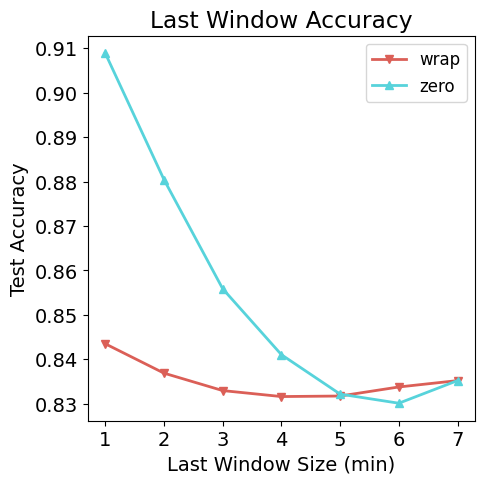

In [130]:
xs = sorted(list(accs.keys()))
ys = [accs[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', '^-']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Test Accuracy',
                       title='Last Window Accuracy',
                       set_ticks=True)

plot_e2e.plot(xs, ys, line_fmts[0], color=palette[0], ms=6, label="wrap")

xs_zero = sorted(list(accs_zero.keys()))
ys_zero = [accs_zero[x] for x in xs_zero]
plot_e2e.plot(xs_zero, ys_zero, line_fmts[1], color=palette[1], ms=6, label="zero")
plot_e2e.ax.legend(ncol=1, fontsize=12)
save_fig(plot_e2e.fig, "./last_window_acc")

In [135]:
df_all_second_zero

,segment,timestamp,label,prediction,oid,index,offset,correct
0,0,2017-10-02 10:26:40,sitting,sitting,154558,116038,60,True
1,0,2017-10-02 10:26:50,sitting,sitting,154558,116038,60,True
2,0,2017-10-02 10:27:00,sitting,sitting,154558,116038,60,True
3,0,2017-10-02 10:27:10,sitting,sitting,154558,116038,60,True
4,0,2017-10-02 10:27:20,sitting,sitting,154558,116038,60,True
...,...,...,...,...,...,...,...,...
3574867,0,2017-11-11 23:23:00,sitting,sitting,153769,112037,66,True
3574868,0,2017-11-11 23:23:10,sitting,sitting,153769,112037,66,True
3574869,0,2017-11-11 23:23:20,sitting,sitting,153769,112037,66,True
3574870,0,2017-11-11 23:23:30,sitting,sitting,153769,112037,66,True


In [148]:
df_all_second_zero["minute_index"] = df_all_second_zero.groupby(["oid", "index", "offset"]).cumcount()

In [170]:
df_all_second_wrap["minute_index"] = df_all_second_wrap.groupby(["oid", "index", "offset"]).cumcount()

In [171]:
def get_df_min(minute, df_all_second):
    start_index = (minute - 1) * 6
    end_index = minute * 6
    df_min = df_all_second[
        (start_index <= df_all_second['minute_index'])
        & (df_all_second['minute_index'] < end_index)]
    accs_min = get_acc(df_min)
    return accs_min

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

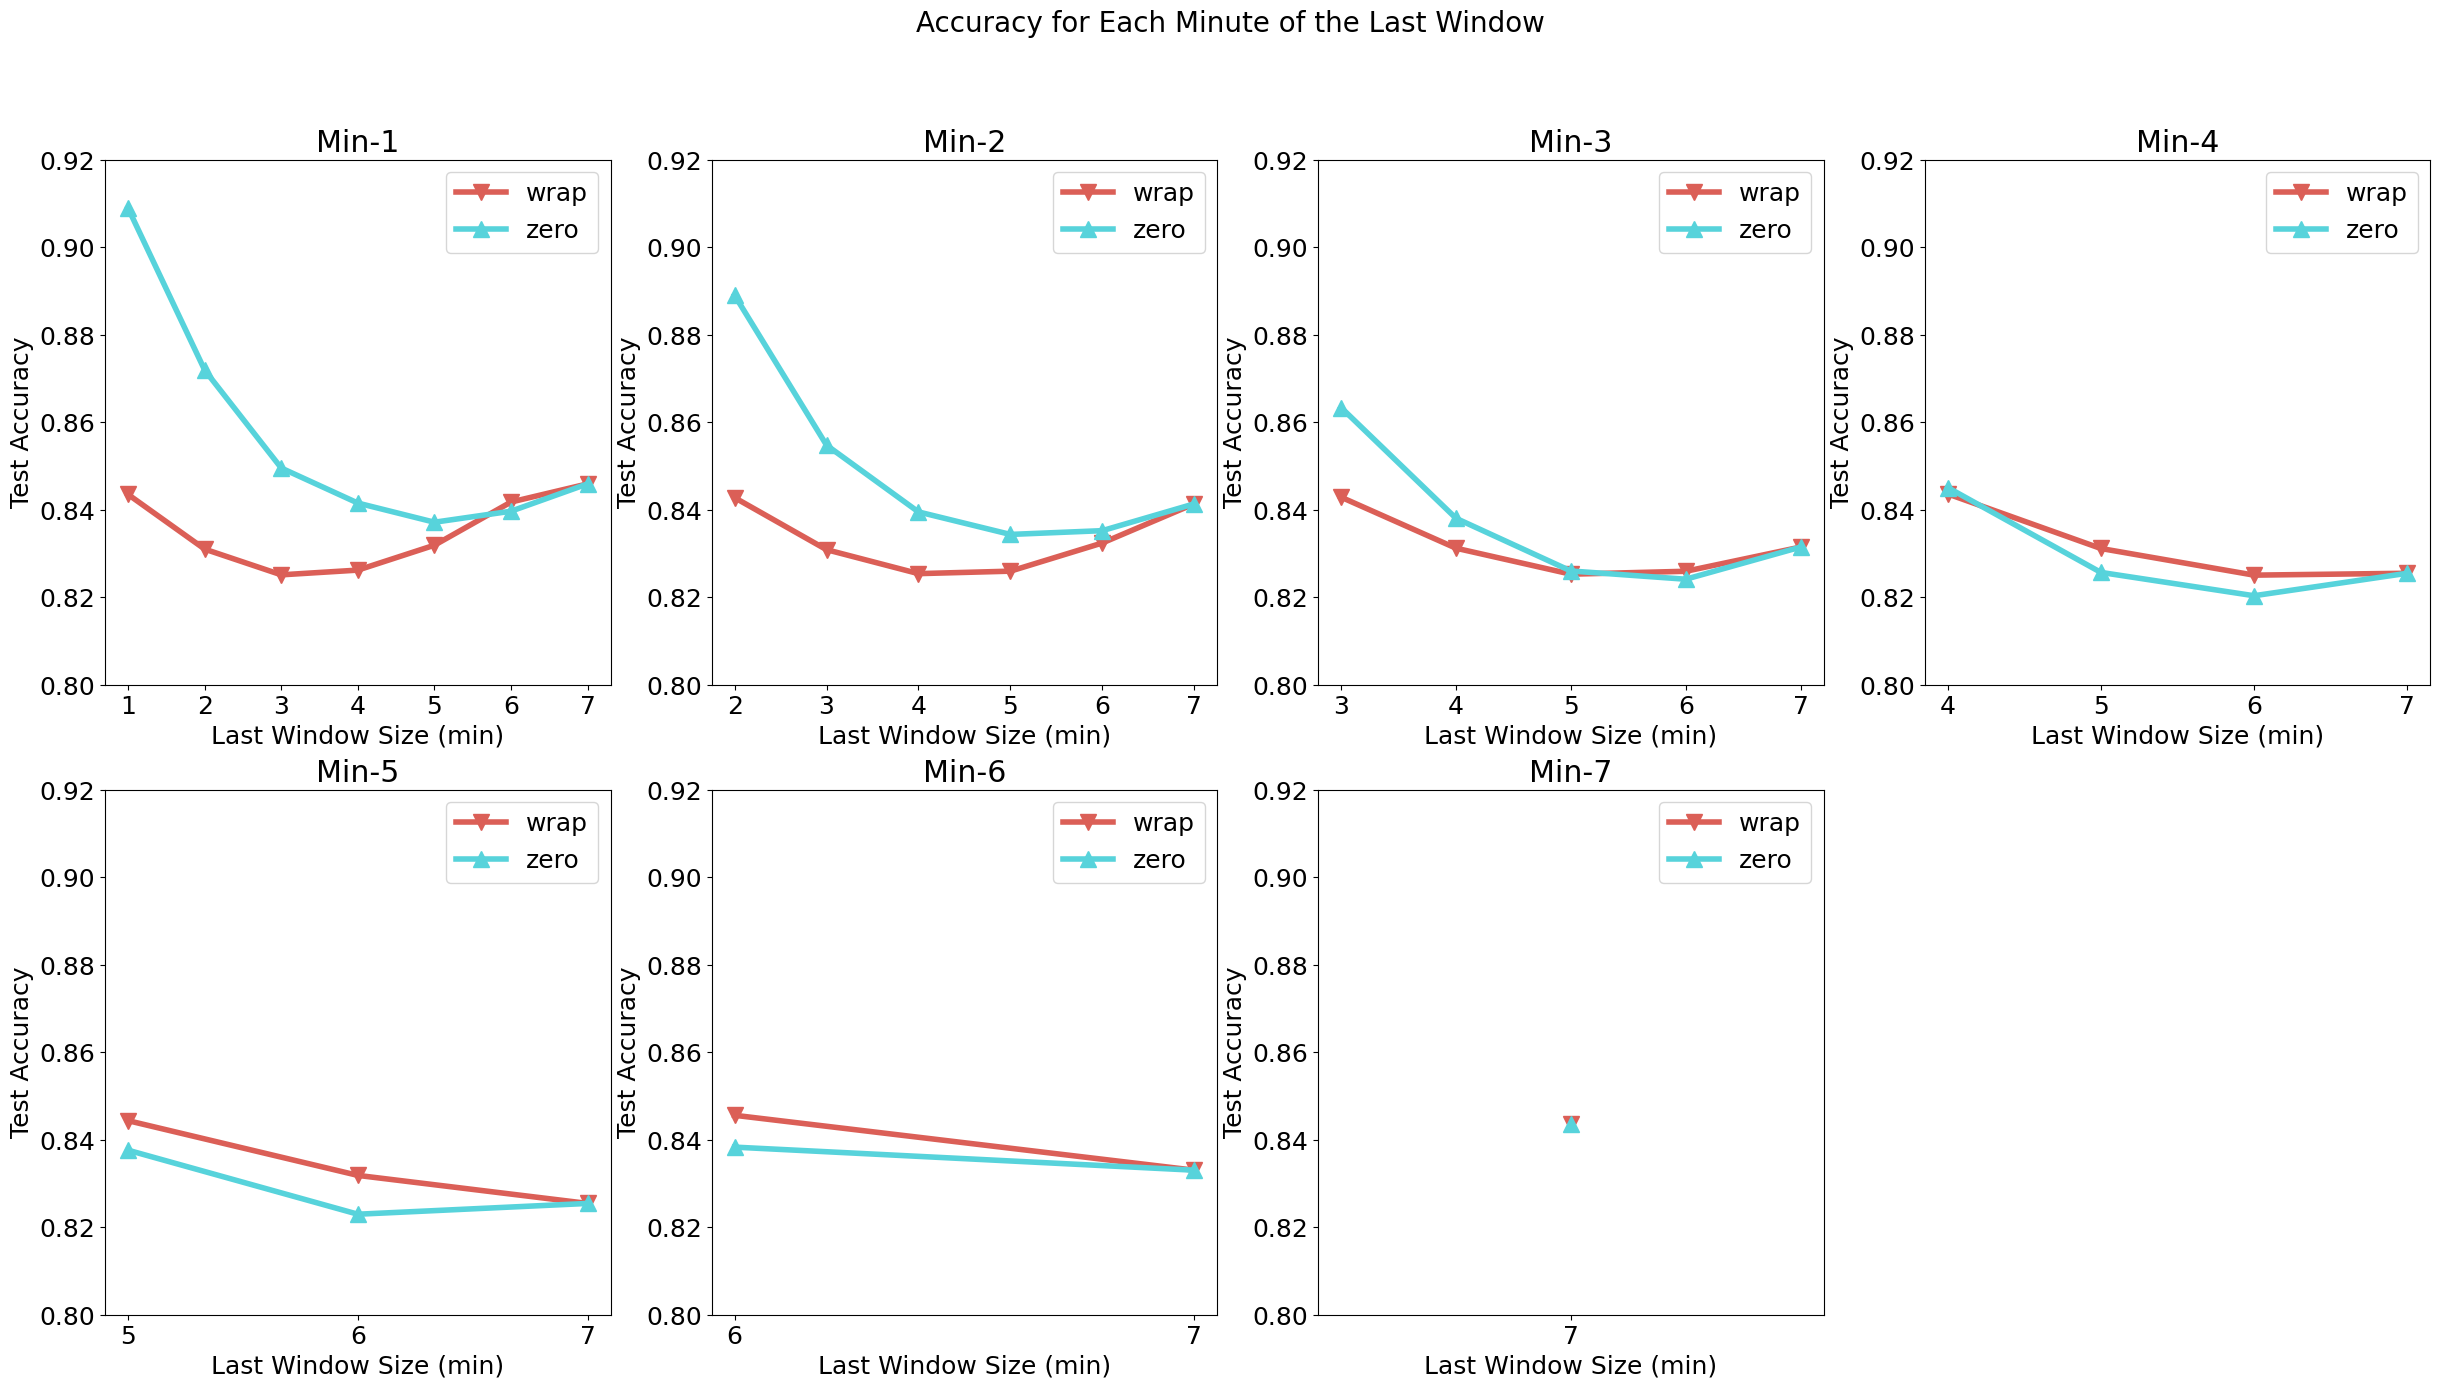

In [200]:
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', '^-']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
axes[-1][-1].set_axis_off()
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('pdf', fonttype=42)
for minute, ax in zip(np.array([x for x in range(1, 8)]), axes.flatten()):
#     plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
#                                ylabel='Test Accuracy',
#                                title='Last Window Min-{} Accuracy'.format(minute),
#                                set_ticks=True)
#     name = "last_window_acc_{}".format(minute)
    for df_all_second, color, fmt, label in zip([df_all_second_wrap, df_all_second_zero], palette, line_fmts, ['wrap', 'zero']):
        accs_min = get_df_min(minute, df_all_second)
        xs = sorted(list(accs_min.keys()))
        ys = [accs_min[x] for x in xs]

        ax.plot(xs, ys, fmt, linewidth=4, color=color, ms=12, label=label)
        ax.set_xticks(xs)
        ax.set_xlabel("Last Window Size (min)")
        ax.set_ylabel("Test Accuracy")
        ax.set_title("Min-{}".format(minute))
        ax.legend(ncol=1, fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        ax.set_ylim(0.8, 0.92)
#     save_fig(plot_e2e.fig, "./figures/{}".format(name))
fig.suptitle('Accuracy for Each Minute of the Last Window', fontsize=20)
save_fig(fig, "./figures/last_window_acc_per_minute")

In [189]:
fig.suptitle('Last Window Accuracy Per Minute', fontsize=16)

Text(0.5, 0.98, 'Last Window Accuracy Per Minute')